In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=500,precision=3,suppress=True)

In [7]:
!git clone https://github.com/vincentvigon/assets_signal

致命错误：目标路径 'assets_signal' 已经存在，并且不是一个空目录。


## Code récupéré dans le TP précédent


La classe suivante permet de décomposer un signal dans une base `basis`.

In [8]:
"""The begin of the sinCos family, stacked in a matrix.
The n-th line is the discretization of sc_n(t)"""
def compute_sinCos_basis(t,T,M):
    """
    Args:
         t (1d-array) : time discretized
         T (int) : Duration
         M (int) : number of different frequencies, so the size of the basis is 2N+1
    """

    basis_sc=np.empty([2*M+1,len(t)])
    basis_sc[0]=np.ones_like(t)/np.sqrt(2)
    for i in range(1,M+1):
        basis_sc[2*i-1,:]=np.sin(i*2*np.pi*t/T)
        basis_sc[2*i,:]=np.cos(i*2*np.pi*t/T)

    return basis_sc

In [9]:
#the informatic version of the scalar product.
#The integral is approximate by a sum
def dot(f,g):
    return 2*np.sum(f*g)/len(f)

In [10]:
class Decomposer:

    def __init__(self,t,basis,dot_fn,dtype=np.float64):

        self.t=t
        self.basis=basis
        self.dot=dot_fn
        self.dtype=dtype


    def check_ortho(self):

        nb=len(self.basis)


        res=np.empty([nb,nb],self.dtype)
        for i in range(nb):
            for j in range(nb):
                res[i,j]=self.dot(self.basis[i,:],self.basis[j,:])
        print(res)


    def compute_coordinates(self,f,plotThem=False):


        coordinates=np.empty(len(self.basis),dtype=self.dtype)

        for i in range(len(self.basis)):
            coordinates[i]=self.dot(f,self.basis[i,:])

        if plotThem:
            plt.plot(range(len(self.basis)),self.OUT_coordinates,".")

        return coordinates



    def compute_approximations(self,f,approx_indexes,plotThem=False):


        assert max(approx_indexes)<=len(self.basis), "approximation index can not be greater than the size of the basis"

        coordinates=self.compute_coordinates(f)


        """each line of the folowing matrix represent an approximation f_N of the signal f """
        approximations=np.empty([len(approx_indexes),len(self.t)],dtype=self.dtype)


        for i,j in enumerate(approx_indexes):
            coor_troncated=coordinates.copy()
            coor_troncated[j:]=0
            approximations[i,:]=coor_troncated@self.basis


        if plotThem:
            nb=len(approx_indexes)
            if nb<=1: nb=2 # to avoid a bug when we write axs[i]
            fig,axs=plt.subplots(nb,1,figsize=(8,nb*2))


            for i in range(len(approx_indexes)):
                axs[i].plot(self.t,f)
                axs[i].plot(self.t,approximations[i,:])
                axs[i].set_title("sum of "+str(approx_indexes[i])+" terms")

            fig.tight_layout()


        #sauvegarde pour les méthode plus bas
        self.OUT_approximations=approximations
        self.approx_indexes=approx_indexes
        self.f=f


        return approximations



    def compute_L2_error(self):

      assert self.OUT_approximations is not None, "Call compute_approximations() before compute_L2_error()."


      L2_error=np.empty(len(self.approx_indexes),dtype=self.dtype)

      for i in range(len(self.approx_indexes)):
        L2_error[i]=np.sqrt( dot(self.f-self.OUT_approximations[i], self.f-self.OUT_approximations[i]) )


      return L2_error



    def compute_Loo_error(self, plotThem=False):

      assert self.OUT_approximations is not None, "Call compute_approximations() before compute_Loo_error()."

      Loo_error=np.empty(len(self.approx_indexes),dtype=self.dtype)

      Loo_error = np.max(np.abs(self.f - self.OUT_approximations), axis=1)

      return Loo_error


## Exponential decomposition


The sinCos decomposition is easy to understand because the basis function take real values. But for computations, a more pratical basis is the exponential family.

### Theory in one theorem


We work now with signals that take complexe values. They are still defined on the time interval $[0,T]$. We need now an hermitian product:
$$
\forall f,g \qquad \mathtt{her}(f,g) = \frac 1 T \int_0^T f(t) \bar{g}(t) \, dt
$$
Where $\bar{g}(t)$ is the complexe-conjugate of $g(t)$.


***Yo you:*** If you never met an hermitian-produc beforet, no problem. It is just a little variant of a dot-product. Now we try to point out the difference (As usual, it is not necessary to make some research on internet):
* $(1\heartsuit)$ What replace the symetry?
* $(1\heartsuit)$ $g\to \mathtt{her}(f,g)$ is not exatly linear. Why?
*  $(1\heartsuit)$ Show that the third axiom of the dot product is still valid.


We define the expontial family  $(e_n)_{n\in \mathbb Z}$ by:
$$
e_n(t) = e^{2i\pi \frac {nt} T }
$$
where $i=\sqrt{-1}$.



***The 3 points theorem, exponential version***

* The familly $(e_n)_{n\in \mathbb Z}$ is orthonormal for the hermitian product $\mathtt{her}()$
* Complex-signals $f$ can be writed:
$$
f(t) = \sum_{n\in \mathbb Z} \alpha_n e_n(t)
$$
    * The sum converges for every $t$ where $f$ is continuous
    * morover, when $f$ is continuous and $f(0)=f(T)$ the convergence is uniform.

* The coordinates $\alpha_n$ are easy to compute:
$$
\alpha_n= \mathtt{her}(f,e_n)
$$


***Comments:***

* The first point is elementary (it is an exercise below)
* The second point is the difficult part. It means that  $(e_n)$ is a sort of basis for complex-signals.
* The expression of $\alpha_n$ comes from the orthonormality.
* The coordinates $\alpha_n$ are called the 'exponentail Fourier coefficients'. Sometimes we denote them by $\alpha_n(f)$ or $\hat f(n)$ or $\mathbb F[f]_n$
* Be careful, $\mathtt{her}(e_n,f)$ would not give $\alpha_n$ but ... $(1\heartsuit)$.


***To you:***

* $(2\heartsuit)$ Check the orthonormality. You just need to know the primitive of the exponential.
* $(2\heartsuit)$ From the orthonormality of the exponential family, deduce the orthonormality of the sinCos family. Help: use these facts:
    * $\mathtt{dot}(f,g)= 2  \mathtt{her}(f,g)$ when $f,g$ take real values.
    * $\cos_n=\frac {e_n + e_{-n}} 2$
    * $\sin_n = \dots $
    

### complex numbers in python

In [11]:
(2+1j*4)*1j #1j is sqrt(-1)

(-4+2j)

In [12]:
np.exp(1j*np.pi)

(-1+1.2246467991473532e-16j)

***To you:*** $(1\heartsuit)$ Why is there a non-zero imaginary part in the number above?

### Practice

In [13]:
T=2
t=np.linspace(0,T,200,endpoint=False)

In [14]:
def compute_basis_exp(t,T,M):

    basis=np.empty([2*M+1,nb_points],dtype=np.complex128)

    for n in range(-M,M+1):
        basis[n+M,:]=np.exp(+2*1j*np.pi*n*t/T)

    return basis

In [15]:
M=5
N=2*M+1
basis_expo=compute_basis_exp(t,T,M)
basis_expo.shape,basis_expo.dtype

NameError: name 'nb_points' is not defined

In [ ]:
fig,axs=plt.subplots(N,2,figsize=(8,N),sharex=True,sharey=True)

for n in range(-M,M+1):
    i=M+n
    axs[i,0].plot(t,np.real(basis_expo[i,:]))
    axs[i,1].plot(t,np.imag(basis_expo[i,:]))
    axs[i,0].set_title("real part, n=%d"%n)
    axs[i,1].set_title("imag part, n=%d"%n)

fig.tight_layout()

In [ ]:
def her(f,g):
    return np.sum(f*np.conj(g))/len(f)

In [ ]:
decomposer_expo=Decomposer(t,basis_expo,her,dtype=np.complex128)

In [ ]:
decomposer_expo.compute_approximations(t*(2-t)**2+1,[2,5,7,9,11],True);

***To you:***

* $(2\heartsuit)$ Can you explain why the orange curve is so far from the blue one in the first approximations? Help: read the next question.
* $(1\heartsuit)$ Imagine a better ordering of the basis to avoid this problem. Bonus: you can code it, and restart the `Decomposer` with you re-ordered basis.

### Change of coordinates


Every real signal $f$ can be writen in two differents ways: as combinaison of $(\frac 1 {\sqrt 2},\cos_n,\sin_n)$ or as a combinaison of $(e_n)$.


To pass from one to the other decomposition, we can compute some change of coordinates:







For $n > 0$:

\begin{align}
\alpha_n&=  {1\over T} \int f \, \bar e_n \\
&= {1\over T} \int f \, (\cos_n - i \sin_n) \\
\end{align}

...



***To you:*** $(1\heartsuit)$ Complete the computation above for the cases $n>0$, $n < 0 $ and $n=0$.  

***To you:*** $(2\heartsuit)$ Find a formula in the other sens: exprime $(a_{n})$ according to $(\alpha_n)$.  




***To you:*** $(1\heartsuit)$  Under which condition on $f$ the exponential-Fourier coefficients are real.

Help: We must see under which condition $\Im(\alpha_n)$ cancel. We have:
$$
\Im(\alpha_n) = \frac 1 T \int_0^T \Im(f \bar e_n)
$$
Write $f=g+ih$ (with $g,h$ real functions) and $\bar e_n=\cos_n - i\sin_n$. Make the product, extract the imaginary part, and see the conditions.


### Hermitian symetry


***To you:*** Prove that, when $f$ is a real signal, their complex Fourier coefficients satisfy $\alpha_{-n}=\overline{\alpha_n}$




In [ ]:
alpha=decomposer_expo.compute_coordinates(t*(2-t)**2+1)
print(alpha)

In [ ]:
fig,axs=plt.subplots(2,1)
axs[0].plot(np.real(alpha),'.')
axs[1].plot(np.imag(alpha),'.');
axs[1].set_xticks(range(0,N))
axs[1].set_xticklabels(range(-M,M+1));

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.abs(alpha),'.');

### Spectrum

Here we just give some important vocabulary.


* The spectrum is simply the family of Fourier coefficients (=coordinates):
$
\mathtt{spectrum}=(\alpha_n)_{n\in \mathbb Z}
$
* The amplitude spectrum is the module of the spectrum:
$
\mathtt{amplitude\_spectrum}=( |\alpha_n|)_{n\in \mathbb Z}
$
* When the signal is real, because of the hermitian symetry, we often consider only the half spectrums:
$
\mathtt{half\_spectrum}=(\alpha_n)_{n\in \mathbb N}
$
* And is amplitude version:
$
\mathtt{half\_amplitude\_spectrum}=(|\alpha_n|)_{n\in \mathbb N}
$
* Because we work with a limited computer (what a pity), we only plot part of the spectrums, which are actually the spectrums of the approximations of the signals:
$
\mathtt{truncated\_spectrum}=(\alpha_n)_{|n|\leq M}
$
* And of course, we could use only a 'half' and 'amplitude' version of the truncated spectrum.


***To you:*** $(2\heartsuit)$ Plot the truncated version of the half-amplitude-spectrum of our signal. Help: modify the previous code.


## Exo: Signal filtering

The two main applications of signals decompostion are:

* Signal filtering: Every signal can be decompose into a sum of elementary waves (ex: sinCos) with given frequency. To filter a signal is to keep only a part of these waves:
    * Low-pass filters suppress all waves with high frequencies
    * High-pass filters suppress all waves with low frequencies
    * Band-pass filters suppress all waves whose frequencies does not belong to a given band, ex: [50Hz,2000Hz]
    
* Signal compression: Actually it is the same as filtering: we keep only waves that are visible, and suppress others to compress.



In [ ]:
"""Here is a noisy signal"""
f_noisy=np.loadtxt("assets_signal/signalToFilter.txt")

In [ ]:
"""Its duration is 2 seconds"""
T=2
t=np.linspace(0,T,2000)
plt.plot(t,f_noisy);

***To you:*** In this exercise, I ask you to not use the `Decomposer`. To write all formulas explicitly will help you to remember them. It is even beter to not use copy-past at all.

* $(3\heartsuit)$ Decompose the noisy signal in the sinCos basis. Be careful, this signal has some high frequencies (=noise).
* $(2\heartsuit)$ Make a nice plot of the amplitude-spectrum (truncated of course).
* $(4\heartsuit)$ Suppress the noise of this signal, keeping only one frequency. Plot this denoised signal, plot it togeter with its spectrum. Help: to make nice plot you can plot on the same window the signal dans its approximation. You can also put the original spectrum and the filtrered spectrum one over the other.

## Perfect sampling

### We were perfect!

Perhaps something seemed you strange in all the previous code: Everywhere we have approximate the integrals by the rectangle method (a non-so-good method), but however, our basis function were perfectly orthogonal: the dot-products were exactly $0$ or $1$!

Observe the following code to see the trick.


In [ ]:
T=2

In [ ]:
t_perfect=np.linspace(0,T,100,endpoint=False)

In [ ]:
basis_sc_perfect=compute_sinCos_basis(t_perfect,T,5)

In [ ]:
decomposer_perfect=Decomposer(t_perfect,basis_sc_perfect,dot)
decomposer_perfect.check_ortho()

In [ ]:
decomposer_perfect.compute_approximations((t_perfect-1)**2,[5,11],True);

In [ ]:
t_bad=np.linspace(0,T,100) #endpoint=True by default
f_bad=(t_bad-1)**2
print(t_bad)

In [ ]:
basis_sc_bad=compute_sinCos_basis(t_bad,T,5)

In [ ]:
decomposer_bad=Decomposer(t_bad,basis_sc_bad,dot)
decomposer_bad.check_ortho()

In [ ]:
decomposer_bad.compute_approximations(f_bad,[5,11],True);

Explanation: To be perfect: you must discretize $[0,T]$ regularly but without adding the point $T$!. It is quite intuivive: When you prolongate periodically the functions, the point $T$ is equivalent to the point $0$, so it is better to not add it as a discretisation point.

When you make the perfect discretization,  the elements of the sinCos family becomes vectors that are exactly orthogonals according to the discrete dot-product which is:
$$
\mathtt{dot_{dis}}(f,g) =\frac 1N \sum_{n} f(x_n) g(x_n)
$$
where $x_n$ are the discretisation points.


To work directly with orthogonals vectors, and not with continuous-time functions, is the basic principle of the discrete Fourier decomposition that we will see in the next chapter.

When you use an non-perfect discretization, the sinCos becomes only almots-orthogonal, and the approximations are worse.

## Défi prog: Orthogonal polynomials $\flat$

We finish by an example, that show that there are others orthogonal basis. Legendre polynomials are often use in numerical analysis to make numerical integration: the idea is to approach function by polynomial (as we did with sinCos), and then to compute the integral exactly (because it is easy to extract the primitive of a polynomial).

But we will see is really more complicated to get a perfect discretisation of the Legendre basis.


***Definition:*** Legendre polynomials are defined on $[-1,+1]$ recursivly by:
\begin{align*}
n P_n(x)&=  (2n-1) x P_{n-1}(x)- (n-1) P_{n-2}(x)\\
P_0&=1\\
P_1&=x
\end{align*}

They are orthogonal with respect to the dot-product:
$$
\mathtt{dot} (f,g) = \int_{-1}^{+1} f(x)g(x) \, dx
$$


To make a perfect discretization of $(P_0,...,P_n)$, we need to consider some special points: the Gauss-points which are the roots of $P_{n+1}$. Let us denote by$(x_0,...,x_n)$ these points. The discrtised family $(P_0,...,P_n)$ is orthogonal with respect to the discrete weighted dot-product:
$$
\mathtt{dot_{dis}} (f,g) = \sum_{i=0}^n w_i f(x_i) g(x_i)
$$
where $w_i$ are some weights.



Next we get the Gauss points and the corresponding weights from `scipy`:

In [ ]:
import scipy.special as spe

degreeMax=19
''' the working interval is [-1,1], we cut it into nbStep points'''
nbStep=50
""" The Gauss point, and their associated weights"""
x, w, _ = spe.roots_legendre(nbStep, True)
print("discrétisation:",x)

plt.plot(x, w, '.');

***To you:*** Let's define the legendre basis, sampled at the gauss points `x`. Stack them in the rows of a matrix `basis`. We you plot them you will optain such a result:

    for i in range(len(basis)):
        plt.plot(x,basis[i,:])

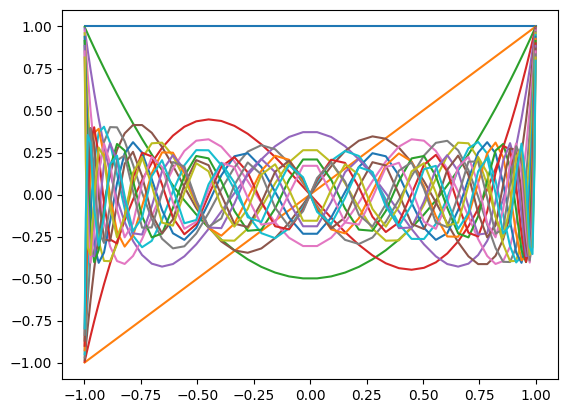

***To you:*** Compute all the dot products. Bonus: make this without loop, juste with matricial products `@`. Hint: to weights the sum, use the following diagonal matrix:

    W=np.diag(w)




You must have remark that the legendre family is orthogonal but not orthonormal. So define a new matrix `basisNor` whose lignes are orthonormal vectors for our special dot product.

As usual, for all following points, make  plots.

* compute the approximation of the vector `y = np.sqrt(np.abs(x))` as a linear combinaison of legendre polynomials.

* find an other vector where the gipps phenomenon is visible.

* Observe the case where the number of element of the basis is equal to the number of discretisation points. Ex: `degreeMax=19` and `nbStep=20`.

## Hilbertian theory $\flat$

Here is a more theoretical part. But howerver, very simple (trust me).

### Hilbertian basis


If you consider that signal are square integrable function on $[0,T]$, then the sinCos-wave-basis or exponential-wave-basis are Hilbertian basis, which means that the approximations converge in $L_2$ norm.





* Denote by $L_2([0,T]\to \mathbb C)$ the set of functions from $[0,T]$ to $\mathbb C$ which are square integrable. For every $f$ in this space:
$$
\| \sum_{n=-M}^M \mathtt{her}(f,e_n)\, e_n   -   f  \| \to 0
$$
with $\|g\|^2=\mathtt{her}(g,g)$.


* Denote by $L_2([0,T]\to \mathbb R)$ the set of functions from $[0,T]$ to $\mathbb R$ which are square integrable. For every $f$ in this space:
$$
\| \sum_{n=0}^N \mathtt{dot}(f,sc_n)\, sc_n   -   f  \| \to 0
$$
with $\|g\|^2=\mathtt{dot}(g,g)$.

* Actually, the second point above is also true for function $f \in L_2([0,T]\to \mathbb C)$: you just have to add a conjugaison in the dot-product to change it on an hermitian product: $\mathtt{dot}(f,g)= \frac 2T \int_0^T f \bar g$.

### Fourier transform as an isometry



Let us change  notations  for Fourier coefficients:
* $\mathbb F_{sc}[f]_n =\mathtt{dot}(f,sc_n)$
* $\mathbb F_{e}[f]_n = \mathtt{her}(f,e_n)$


It is interesant to considere the applications that, to a function, associate the Fourier coefs (=the spectrum).

* $f\to \mathbb F_{sc}[f]$ is a bijection from $L_2([0,T]\to \mathbb R)$ to $\ell_2(\mathbb N \to \mathbb R)$
* $f\to \mathbb F_{e}[f]$ is a bijection from $L_2([0,T]\to \mathbb C)$ to $\ell_2(\mathbb Z \to \mathbb C)$

But also:
* $f\to \mathbb F_{e}[f]$ is a bijection from $L_2([0,T]\to \mathbb R)$ to the set of the hermitian elements of $\ell_2(\mathbb Z \to \mathbb C)$.



And we have these Plancherel-Parseval identities:
$$
\mathtt{dot}(f,g) = \sum_{n\in \mathbb N} \mathbb F_{sc}[f]_n \,  \mathbb F_{sc}[g]_n
$$
$$
\mathtt{her}(f,g) = \sum_{n\in \mathbb Z} \mathbb F_{e}[f]_n \,  \mathbb F_{e}[g]_n  
$$
which indicates that both $\mathbb  F$ are $L_2$-isometries.

***To you:***
* $(1\heartsuit)$ Correct the small mistake in one of the equation above.
*  $(2\heartsuit)$ Prove them. Help: it is just a consquence of the orthonormality. To be rigourous, you must also invocate the continuity of the dot and hermitian products.

***To you:*** Considere an approximation $f_{fitred}$ of the signal $f$ make by suppressing some term in the sinCos-Fourier serie. Ex:

* You keep only cosinus
* You keep only sinus
* You keep only low frequencies waves
* You keep only high frequencies waves
* You suppress the constant term
* etc.

How can you define $f_{fitred}$ in term of projection $(2\heartsuit)$?



### Energy of a signal


The mean energy of a signal $f$ si define by
$$
E(f)=\frac 1 T \int_0^T |f'(t)|^2\, dt
$$



***To you:***
* Which is the energy of a wave $e_n$?
* Which is the energy of a signal $f$ (expressed from its exponential-Fourier coef)?
* Does a low-pitched sound (grave) is more energetic than  an high-piched sound (=aigu)?
* Try to express the energy directly in term of exponential-Fourier-coefficients (a similar formula exists for sinCos-Fourier-coef of course).




***Remark:*** In most of signal books,  the ernergy is simply defined as $\int_0^T |f(t)|^2\, dt$ (no derivation). But it depends of the physical meaning of $f$. Ex: if it is a pressure:  with constant pressure, you cannot produce energy at all, so the energy formula must incorporate the derivation of the signal.



### Correction

Commençons par calculer l'énergie moyenne d'une vaguellette élémentaire:

$$
E(e_n)=\frac 1 T \int_0^T |e_n'(t)|^2\, dt  = ...
$$





Passons maintenant au cas général:

En utilisant le fait que Fourier est une isométrie:
$$
\frac 1 T \int_0^T |f'|^2 = \sum_n |\alpha_n(f')|^2
$$



Par ailleurs:
$$
\alpha_n(f') = \frac 1 T \int_0^T f' \bar e_n = ...
$$

